# HeMIS Model

Note: workflow has been adapted from the example at https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
<br>The dataset is imported from the master files already split on paired images, AP images, and L images.
<br>A dataset object is setup to preprocess and augment images, the model is defined with DenseNet121 models as a backbone, then the model is trained and tested with and without augmentations for both the anterior and posterior datasets.

## Import required libraries

In [1]:
import sys  
sys.path.insert(0, '../')
import tqdm
import torch
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import lr_scheduler
import time
import copy
import cv2
import sys  
sys.path.insert(0, '../../workspace/')
sys.path.insert(0, '../utilities/')
import os, os.path as osp
import pandas as pd
import pydicom
import json
import re
import pickle
import sklearn
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
import preprocessing_function
import metrics
from utilities import helper_functions, splitting, augmentations
from PIL import Image
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', 400)

## Define Dataset

In [2]:
class ViewsDataset(Dataset):
    
    def __init__(self, img_paths, labels, augmentation_function, png=True):
        '''
        Initialize the dataset with image paths, their corresponding Y labels (in numpy format)
        '''        
        self.img_files = img_paths
        self.labels = labels
        self.augmentation = augmentation_function
        self.png = png
        
    def load_png(self, img_path):
        '''
        This function loads an image from a PNG path
        '''
        try:
            if img_path is not np.nan:
                actual_image = cv2.imread(img_path)
            else:
                actual_image = np.zeros((3,256,256)).astype(np.uint8)
        except:
            actual_image = np.zeros((3,256,256)).astype(np.uint8)
        
        actual_image = Image.fromarray(actual_image, mode="RGB")
        
        return actual_image
    
    def load_dicom(self, img_path):
        '''
        This function loads an image from a DICOM path. If there is an error with the path, it will print error and 
        return a 256x256 array of zeros
        '''
        try:
            image_info = pydicom.dcmread(img_path)
            actual_image = image_info.pixel_array
            
        except:
            actual_image = np.zeros((256,256))
        
        actual_image = helper_functions.prepare_image(actual_image, rgb=True, channels_first=True)
        
        if self.augmentation is not None:
            actual_image = Image.fromarray(actual_image, mode="RGB")
        else:
            actual_image = torch.as_tensor(actual_image/255.)

        return actual_image
    
    def __getitem__(self, index):
        '''
        Get a unique item from the dataset according to index. This is required when building a custom dataloader
        '''
        img_row = self.img_files.iloc[index,:]
        
        if (self.png):
            AP_view = self.load_png(img_row.filepath_AP)
            L_view = self.load_png(img_row.filepath_L)
        else:
            AP_view = self.load_dicom(img_row.filepath_AP)
            L_view = self.load_dicom(img_row.filepath_L)
        
        if self.augmentation is not None:
            AP_view = self.augmentation(AP_view)
            L_view = self.augmentation(L_view)
        
        Y = self.labels[index]
        
        return (AP_view.float(), L_view.float()), torch.as_tensor(Y).long()
        
    
    def __len__(self):
        '''
        Length of the dataset. This is required when building a custom dataloader
        '''
        return len(self.img_files)

## Define HeMIS Model

In [3]:
class HeMISModel(nn.Module):

    def __init__(self, AP_model, L_model, num_classes, dropout):
        
        super(HeMISModel, self).__init__()
        
        # AP_model is a DenseNet-121 model used to process AP views when L view unavailable        
        self.AP_model = AP_model
        # L_model is a DenseNet-121 model used to process L views when AP view unavailable
        self.L_model = L_model
        
        # take AP_model and L_model until after their third dense blocks for use in the AuxLoss model
        # take the end blocks from the AP model
        for count, child in enumerate(self.AP_model.named_children()):
            if (count==0):
                self.AP_blocks = child[1][0:10]
                self.end_blocks = child[1][10:]
        for count, child in enumerate(self.L_model.named_children()):
            if (count==0):
                self.L_blocks = child[1][0:10]
        
        self.dropout = nn.Dropout(p=dropout)
        
        # apply a fully connected layer after concat/mean of the first 3 dense blocks of the AP/L models 
        # 131072 is the flattened dimension after passing 2 images (mean and var) through the first 4 blocks of DenseNet-121 (2*1024*8*8)
        self.fc = nn.Linear(131072, num_classes)
    
    def forward(self, x):
        '''
        Forward pass through the network
        '''
        x_AP = x[0]
        x_L = x[1]
        x_AP_orig = x_AP
        x_L_orig = x_L
        device = 'cuda:0' # use cuda 0
        
        # put AP and L images through first 3 blocks of their DenseNet models
        # both return shapes of [batch, 512, 8, 8]
        for block in self.AP_blocks:
            x_AP = block(x_AP)
        for block in self.L_blocks:
            x_L = block(x_L)
        
        # take mean and variance of the AP and L blocks
        x_AP = torch.unsqueeze(x_AP,1) # returns dimension [batch,1,512,8,8]
        x_L = torch.unsqueeze(x_L,1) # returns dimension [batch,1,512,8,8]
        x = torch.cat([x_AP, x_L], dim=1) # returns dimension [batch,2,512,8,8]
        x_mean = x.mean(dim=1) # returns dimension [batch,512,8,8]
        x_var = x.var(dim=1) # returns dimension [batch,512,8,8]
        
        if ((x_AP_orig.cpu().numpy().any()==False) or (x_L_orig.cpu().numpy().any()==False)):
            x_var = torch.zeros(x_var.shape).to(device)
        
        # concat the variance and mean
        x = torch.cat([x_mean, x_var],3) # returns dim [batch,512,8,16]

        # put the concat of the mean and variance through the remaining DenseNet block and pooling layer
        # outputs [batch, 1024, 16, 8]
        for block in self.end_blocks:
            x = block(x)
        x = x.view(x.size(0),-1) # reshape so that input to classifier is [batch, 1024*16*8]
        x = self.dropout(x)
        x = self.fc(x) # linear classifier is [1024, num_classes]

        return x

## Define Training Function

In [4]:
def train_model(dataset, model, criterion, optimizer, scheduler, num_epochs, dataloaders):
    since = time.time()
    
    device = 'cuda:0' # use cuda 0
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_epoch_loss = []
    val_epoch_loss = []
    
    for epoch in tqdm.notebook.tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode        
   
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in tqdm.notebook.tqdm(dataloaders[phase]):
                inputs = list(map(lambda x:x.to(device),inputs))
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step() 
                    
                running_loss += loss.item() * inputs[0].size(0)
                running_corrects += torch.sum(preds == labels.data)
                    
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataset[phase])
            epoch_acc = running_corrects.double() / len(dataset[phase])
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'train':
                train_epoch_loss.append(epoch_loss)
            elif phase == 'val':
                val_epoch_loss.append(epoch_loss)
                
            # deep copy the model based on the best total acc
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # graph training and validation losses
    epoch_array = range(0,num_epochs)
    fig, axs = plt.subplots(2, figsize=(10, 20))
    axs[0].plot(epoch_array, train_epoch_loss, 'b')
    axs[0].set_title('Training Loss vs Epochs')
    
    axs[1].plot(epoch_array, val_epoch_loss, 'b')
    axs[1].set_title('Validation Loss vs Epochs')
    
    fig.tight_layout(pad=3.0)
    
    return model

## Define Testing Function

In [5]:
def evaluate_model(model, dataloaders, criterion, phase='test'):
    '''
    Function to evaluate on test set
    '''
    
    device = 'cuda:0' # use cuda 0
    
    model.eval()   # Set model to evaluate mode        

    running_loss = 0.0
    running_corrects = 0
    running_incorrects = 0
    pred_list = []
    label_list = []
    output_list = []

    # Iterate over data.
    for inputs, labels in tqdm.notebook.tqdm(dataloaders[phase]):
        inputs = list(map(lambda x: x.to(device), inputs))
        labels = labels.to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs[0].size(0)
        running_corrects += torch.sum(preds == labels.data)
        running_incorrects += torch.sum(preds != labels.data)
        pred_list.extend(preds.cpu().tolist())
        output_list.extend(outputs.cpu().tolist())
        label_list.extend(labels.cpu().tolist())
        
    print('Total Correct Predictions: ' + str(running_corrects))
    print('Total Incorrect Predictions: ' + str(running_incorrects))
    
    return np.array(pred_list), nn.Softmax(dim=-1)(torch.Tensor(output_list)).numpy(), np.array(label_list)

## Function for Train Set Normalization

In [6]:
# Function to get mean and standard deviation for normalization
def get_training_mean_std(train_dataset):
    import numpy as np
    
    means = []
    stds = []
    for i in range(len(train_dataset)):
        image = train_dataset.__getitem__(i)[0][0].numpy()
        mean, std = np.mean(image), np.std(image)
        means.append(mean)
        stds.append(std)
        image = train_dataset.__getitem__(i)[0][1].numpy()
        mean, std = np.mean(image), np.std(image)
        means.append(mean)
        stds.append(std)

    return np.mean(means), np.mean(stds)

## Define Function to Create, Train, and Test Model with Default Hyperparams to Compare Against AuxLoss

In [7]:
def create_train_test(master_file, augs=True):
    
    # first split and load the train, val, and test datasets
    Train_Set, Val_Set, Test_Set = splitting.split_data(master_file, 'nonsense', return_data=True, save_data=False)
    
    if (augs):
        # Taking the preprocessed images, need to change the filepath to point at the png area
        Train_Set['filepath_AP'] = Train_Set['filepath_AP'].str[:-4] + "_processed.png"
        Val_Set['filepath_AP'] = Val_Set['filepath_AP'].str[:-4] + "_processed.png"
        Test_Set['filepath_AP'] = Test_Set['filepath_AP'].str[:-4] + "_processed.png"
        Train_Set['filepath_L'] = Train_Set['filepath_L'].str[:-4] + "_processed.png"
        Val_Set['filepath_L'] = Val_Set['filepath_L'].str[:-4] + "_processed.png"
        Test_Set['filepath_L'] = Test_Set['filepath_L'].str[:-4] + "_processed.png"
        
        Train_Set['filepath_AP'] = '..' + Train_Set['filepath_AP'].str[16:]
        Val_Set['filepath_AP'] = '..' + Val_Set['filepath_AP'].str[16:]
        Test_Set['filepath_AP'] = '..' + Test_Set['filepath_AP'].str[16:]
        Train_Set['filepath_L'] = '..' + Train_Set['filepath_L'].str[16:]
        Val_Set['filepath_L'] = '..' + Val_Set['filepath_L'].str[16:]
        Test_Set['filepath_L'] = '..' + Test_Set['filepath_L'].str[16:]
    
        aug_wo_norm = augmentations.apply_augmentations_wo_norm(data_set="train", size_val=256, contrast_val=0.25, 
                                                        hue_val=0.25, grayscale_prob=0.1,
                                                        hflip_prob=0.5, degree_val=0, 
                                                        shear_val=1)
        # Creating train dataset
        train_dataset = ViewsDataset(Train_Set[['filepath_AP', 'filepath_L']], Train_Set['Label'], aug_wo_norm, png=True)
    
        # do augmentation based on entire dataset (instead of AP/L/AuxLoss sets individually)
        dataset_means, dataset_stds = get_training_mean_std(train_dataset)
    
        # Augmentation function with normalization
        param_aug = {'size_val': 256, 'contrast_val':0.25, 
                 'hue_val': 0.25, 'grayscale_prob': 0.1,
                 'hflip_prob': 0.5, 'degree_val':0,
                 'shear_val':1, 'avg_pop_mean': dataset_means, 
                 'avg_pop_std': dataset_stds
        }
        aug_functions = {x: augmentations.apply_augmentations_with_norm(data_set=x, **param_aug) for x in ['train', 'val', 'test']}

    # declare dataloaders
    # batch size of 8 specified in paper
    params = {'batch_size': 8,
              'shuffle': True,
              'num_workers': 1}
    params_test = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 1}
    
    if (augs):
        image_datasets = {
        'train': ViewsDataset(Train_Set[['filepath_AP', 'filepath_L']], Train_Set['Label'], augmentation_function=aug_functions['train']),
        'val': ViewsDataset(Val_Set[['filepath_AP', 'filepath_L']], Val_Set['Label'], augmentation_function=aug_functions['val']),
                }
        image_datasets_test = {
            'test': ViewsDataset(Test_Set[['filepath_AP', 'filepath_L']], Test_Set['Label'], augmentation_function= aug_functions['test'])
                    }
    else:
        image_datasets = {
        'train': ViewsDataset(Train_Set[['filepath_AP', 'filepath_L']], Train_Set['Label'], augmentation_function=None, png=False),
        'val': ViewsDataset(Val_Set[['filepath_AP', 'filepath_L']], Val_Set['Label'], augmentation_function=None, png=False),
                }
        image_datasets_test = {
            'test': ViewsDataset(Test_Set[['filepath_AP', 'filepath_L']], Test_Set['Label'], augmentation_function=None, png=False)
                    }
    
    dataloaders = {x: DataLoader(image_datasets[x], **params) for x in ['train', 'val']}
    dataloaders_test = {x: DataLoader(image_datasets_test[x], **params_test) for x in ['test']}
    
    device = 'cuda:0' # use cuda 0

    # import DenseNet-121 models
    AP_model = models.densenet121(pretrained=True).to(device)
    L_model = models.densenet121(pretrained=True).to(device)

    num_classes = len(Train_Set['Label'].value_counts())

    AP_model.classifier = nn.Linear(in_features=1024, out_features = num_classes)
    L_model.classifier = nn.Linear(in_features=1024, out_features = num_classes)

    # instantiate model
    HeMIS = HeMISModel(AP_model, L_model, num_classes, 0.3).to(device)
    
    # Weights
    value_counts_ = Train_Set['Label'].value_counts().sort_index()
    weights = torch.Tensor(value_counts_.sum()/(len(value_counts_)*value_counts_).tolist())
    
    # create criterion
    criterion = torch.nn.CrossEntropyLoss(weight=weights).to(device)

    # optimizer and learning rate taken from paper
    optimizer = torch.optim.Adam([{'params':HeMIS.AP_blocks.parameters(), 'lr':3.8e-4}, {'params':HeMIS.L_blocks.parameters(), 'lr':2e-5}, {'params':HeMIS.fc.parameters(), 'lr':2.8e-5}, {'params':HeMIS.dropout.parameters(), 'lr':2.8e-5}])

    # scheduler to decay learning rate
    # have decay by half every 3 epochs because it was learning too quickly and overfitting a lot
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    epochs = 30 # used up to 40 epochs (train function has early stopping)

    # train the model
    train_model(image_datasets, HeMIS, criterion, optimizer, exp_lr_scheduler, epochs, dataloaders)
    
    # test the model
    pred_Aux, prob_Aux, label_Aux = evaluate_model(HeMIS, dataloaders_test, criterion)
    
    # get test statistics
    f1_score, precision, recall, auc, confusion_matrix = metrics.metrics_function(pred_Aux, prob_Aux, label_Aux)
    
    # move everything back off of the cuda to try to prevent crashing it
    HeMIS = HeMIS.cpu()
    AP_model = AP_model.cpu()
    L_model = L_model.cpu()
    criterion = criterion.cpu()

        
    return HeMIS, f1_score, precision, recall, auc, confusion_matrix


## Create, Test, Train Models

Epoch 0/29
----------



train Loss: 1.6580 Acc: 0.3777



val Loss: 1.1628 Acc: 0.2623

Epoch 1/29
----------



train Loss: 1.6261 Acc: 0.3844



val Loss: 1.6748 Acc: 0.2869

Epoch 2/29
----------



train Loss: 1.5506 Acc: 0.4307



val Loss: 1.2474 Acc: 0.3893

Epoch 3/29
----------



train Loss: 1.3595 Acc: 0.4329



val Loss: 0.5121 Acc: 0.2623

Epoch 4/29
----------



train Loss: 1.3823 Acc: 0.4904



val Loss: 1.1766 Acc: 0.3975

Epoch 5/29
----------



train Loss: 1.0849 Acc: 0.5930



val Loss: 1.0069 Acc: 0.3156

Epoch 6/29
----------



train Loss: 0.9224 Acc: 0.6460



val Loss: 0.1996 Acc: 0.6680

Epoch 7/29
----------



train Loss: 0.6497 Acc: 0.7294



val Loss: 0.2460 Acc: 0.7008

Epoch 8/29
----------



train Loss: 0.5976 Acc: 0.7554



val Loss: 0.4415 Acc: 0.6393

Epoch 9/29
----------



train Loss: 0.4937 Acc: 0.7756



val Loss: 0.1076 Acc: 0.6803

Epoch 10/29
----------



train Loss: 0.4119 Acc: 0.8129



val Loss: 0.1762 Acc: 0.6475

Epoch 11/29
----------



train Loss: 0.3707 Acc: 0.8388



val Loss: 0.2166 Acc: 0.6270

Epoch 12/29
----------



train Loss: 0.3720 Acc: 0.8422



val Loss: 0.4271 Acc: 0.6926

Epoch 13/29
----------



train Loss: 0.3654 Acc: 0.8377



val Loss: 0.4258 Acc: 0.6311

Epoch 14/29
----------



train Loss: 0.3261 Acc: 0.8489



val Loss: 0.8207 Acc: 0.6598

Epoch 15/29
----------



train Loss: 0.3277 Acc: 0.8602



val Loss: 0.1013 Acc: 0.6270

Epoch 16/29
----------



train Loss: 0.3310 Acc: 0.8331



val Loss: 0.2699 Acc: 0.6680

Epoch 17/29
----------



train Loss: 0.3120 Acc: 0.8534



val Loss: 0.5104 Acc: 0.6393

Epoch 18/29
----------



train Loss: 0.3162 Acc: 0.8546



val Loss: 0.1507 Acc: 0.6475

Epoch 19/29
----------



train Loss: 0.3035 Acc: 0.8501



val Loss: 0.2056 Acc: 0.6475

Epoch 20/29
----------



train Loss: 0.3051 Acc: 0.8546



val Loss: 0.4110 Acc: 0.6230

Epoch 21/29
----------



train Loss: 0.3090 Acc: 0.8681



val Loss: 0.1868 Acc: 0.6434

Epoch 22/29
----------



train Loss: 0.2886 Acc: 0.8703



val Loss: 0.0835 Acc: 0.6393

Epoch 23/29
----------



train Loss: 0.2820 Acc: 0.8703



val Loss: 0.5394 Acc: 0.6516

Epoch 24/29
----------



train Loss: 0.2961 Acc: 0.8715



val Loss: 0.0590 Acc: 0.6475

Epoch 25/29
----------



train Loss: 0.3097 Acc: 0.8625



val Loss: 0.1138 Acc: 0.6639

Epoch 26/29
----------



train Loss: 0.2939 Acc: 0.8749



val Loss: 0.2488 Acc: 0.6598

Epoch 27/29
----------



train Loss: 0.2830 Acc: 0.8703



val Loss: 0.4542 Acc: 0.6557

Epoch 28/29
----------



train Loss: 0.2834 Acc: 0.8737



val Loss: 0.1317 Acc: 0.6434

Epoch 29/29
----------



train Loss: 0.2734 Acc: 0.8771



val Loss: 0.0330 Acc: 0.6352


Training complete in 17m 36s
Best val Acc: 0.700820



Total Correct Predictions: tensor(261, device='cuda:0')
Total Incorrect Predictions: tensor(129, device='cuda:0')


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6636750344926446]
[0.659182675561986]
[0.6692307692307692]
[0.7803588405525632]
[array([[211,  33,  22,   0],
       [ 29,  40,   6,   0],
       [ 17,  12,  10,   0],
       [  7,   2,   1,   0]])]


Epoch 0/29
----------



train Loss: 1.9746 Acc: 0.2520



val Loss: 1.6796 Acc: 0.2632

Epoch 1/29
----------



train Loss: 1.4360 Acc: 0.3984



val Loss: 2.0481 Acc: 0.1842

Epoch 2/29
----------



train Loss: 1.2823 Acc: 0.5285



val Loss: 2.0857 Acc: 0.0789

Epoch 3/29
----------



train Loss: 1.2364 Acc: 0.4553



val Loss: 0.7148 Acc: 0.2895

Epoch 4/29
----------



train Loss: 0.5797 Acc: 0.7317



val Loss: 0.4490 Acc: 0.5263

Epoch 5/29
----------



train Loss: 0.6266 Acc: 0.8049



val Loss: 1.2956 Acc: 0.3947

Epoch 6/29
----------



train Loss: 0.6565 Acc: 0.7480



val Loss: 1.6228 Acc: 0.4737

Epoch 7/29
----------



train Loss: 0.4709 Acc: 0.7805



val Loss: 2.8361 Acc: 0.6053

Epoch 8/29
----------



train Loss: 0.3263 Acc: 0.8130



val Loss: 0.2257 Acc: 0.5789

Epoch 9/29
----------



train Loss: 0.2404 Acc: 0.9106



val Loss: 0.4189 Acc: 0.6053

Epoch 10/29
----------



train Loss: 0.1986 Acc: 0.9350



val Loss: 0.8337 Acc: 0.5789

Epoch 11/29
----------



train Loss: 0.1503 Acc: 0.9593



val Loss: 0.6533 Acc: 0.5789

Epoch 12/29
----------



train Loss: 0.1158 Acc: 0.9756



val Loss: 0.0214 Acc: 0.5789

Epoch 13/29
----------



train Loss: 0.2136 Acc: 0.9512



val Loss: 0.1273 Acc: 0.5789

Epoch 14/29
----------



train Loss: 0.1454 Acc: 0.9675



val Loss: 0.0587 Acc: 0.6053

Epoch 15/29
----------



train Loss: 0.1652 Acc: 0.9756



val Loss: 0.1356 Acc: 0.5789

Epoch 16/29
----------



train Loss: 0.1105 Acc: 0.9837



val Loss: 0.1019 Acc: 0.5789

Epoch 17/29
----------



train Loss: 0.0913 Acc: 0.9756



val Loss: 0.0718 Acc: 0.5526

Epoch 18/29
----------



train Loss: 0.1310 Acc: 0.9675



val Loss: 0.3452 Acc: 0.5526

Epoch 19/29
----------



train Loss: 0.1162 Acc: 0.9756



val Loss: 0.1037 Acc: 0.5789

Epoch 20/29
----------



train Loss: 0.1067 Acc: 0.9756



val Loss: 1.0138 Acc: 0.5526

Epoch 21/29
----------



train Loss: 0.1176 Acc: 0.9756



val Loss: 0.0783 Acc: 0.5526

Epoch 22/29
----------



train Loss: 0.0877 Acc: 1.0000



val Loss: 0.4755 Acc: 0.5526

Epoch 23/29
----------



train Loss: 0.0956 Acc: 0.9756



val Loss: 0.0891 Acc: 0.5526

Epoch 24/29
----------



train Loss: 0.1158 Acc: 0.9837



val Loss: 0.0262 Acc: 0.5526

Epoch 25/29
----------



train Loss: 0.0819 Acc: 0.9756



val Loss: 0.0746 Acc: 0.5263

Epoch 26/29
----------



train Loss: 0.0894 Acc: 0.9837



val Loss: 0.1570 Acc: 0.5526

Epoch 27/29
----------



train Loss: 0.0994 Acc: 0.9919



val Loss: 0.1081 Acc: 0.5789

Epoch 28/29
----------



train Loss: 0.0722 Acc: 0.9919



val Loss: 0.2763 Acc: 0.5789

Epoch 29/29
----------



train Loss: 0.0831 Acc: 0.9919



val Loss: 0.1210 Acc: 0.5789


Training complete in 3m 7s
Best val Acc: 0.605263



Total Correct Predictions: tensor(44, device='cuda:0')
Total Incorrect Predictions: tensor(15, device='cuda:0')


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6875182014095171]
[0.6391786179921772]
[0.7457627118644068]
[0.624488147134706]
[array([[43,  0,  0,  2],
       [ 1,  1,  0,  0],
       [ 4,  1,  0,  1],
       [ 4,  2,  0,  0]])]


Epoch 0/29
----------



train Loss: 1.8880 Acc: 0.4106



val Loss: 0.7317 Acc: 0.5519

Epoch 1/29
----------



train Loss: 1.9252 Acc: 0.3994



val Loss: 2.6683 Acc: 0.2778

Epoch 2/29
----------



train Loss: 1.7346 Acc: 0.4177



val Loss: 1.2335 Acc: 0.4852

Epoch 3/29
----------



train Loss: 1.9340 Acc: 0.4350



val Loss: 1.4026 Acc: 0.6556

Epoch 4/29
----------



train Loss: 1.6771 Acc: 0.4695



val Loss: 1.1076 Acc: 0.2556

Epoch 5/29
----------



train Loss: 1.6611 Acc: 0.4980



val Loss: 3.2897 Acc: 0.2000

Epoch 6/29
----------



train Loss: 1.4648 Acc: 0.5518



val Loss: 2.8441 Acc: 0.4296

Epoch 7/29
----------



train Loss: 1.1672 Acc: 0.6301



val Loss: 1.6991 Acc: 0.5556

Epoch 8/29
----------



train Loss: 1.0159 Acc: 0.7205



val Loss: 0.2095 Acc: 0.6037

Epoch 9/29
----------



train Loss: 0.8539 Acc: 0.7165



val Loss: 1.9593 Acc: 0.5185

Epoch 10/29
----------



train Loss: 0.5967 Acc: 0.8008



val Loss: 0.9025 Acc: 0.4778

Epoch 11/29
----------



train Loss: 0.5529 Acc: 0.8018



val Loss: 0.6936 Acc: 0.5333

Epoch 12/29
----------



train Loss: 0.5304 Acc: 0.8242



val Loss: 0.5729 Acc: 0.4815

Epoch 13/29
----------



train Loss: 0.5205 Acc: 0.8120



val Loss: 0.6150 Acc: 0.5407

Epoch 14/29
----------



train Loss: 0.5107 Acc: 0.7988



val Loss: 0.1816 Acc: 0.5148

Epoch 15/29
----------



train Loss: 0.4471 Acc: 0.8394



val Loss: 0.5010 Acc: 0.5037

Epoch 16/29
----------



train Loss: 0.4643 Acc: 0.8272



val Loss: 0.2401 Acc: 0.5037

Epoch 17/29
----------



train Loss: 0.4949 Acc: 0.8343



val Loss: 0.7755 Acc: 0.4778

Epoch 18/29
----------



train Loss: 0.4497 Acc: 0.8252



val Loss: 0.2780 Acc: 0.5370

Epoch 19/29
----------



train Loss: 0.3902 Acc: 0.8669



val Loss: 0.5995 Acc: 0.5000

Epoch 20/29
----------



train Loss: 0.4248 Acc: 0.8262



val Loss: 0.2184 Acc: 0.5222

Epoch 21/29
----------



train Loss: 0.4325 Acc: 0.8252



val Loss: 0.2822 Acc: 0.5148

Epoch 22/29
----------



train Loss: 0.3543 Acc: 0.8506



val Loss: 0.9102 Acc: 0.5074

Epoch 23/29
----------



train Loss: 0.3869 Acc: 0.8171



val Loss: 0.5802 Acc: 0.4963

Epoch 24/29
----------



train Loss: 0.3614 Acc: 0.8354



val Loss: 0.2932 Acc: 0.4926

Epoch 25/29
----------



train Loss: 0.4180 Acc: 0.8384



val Loss: 0.3138 Acc: 0.5000

Epoch 26/29
----------



train Loss: 0.3832 Acc: 0.8537



val Loss: 0.0985 Acc: 0.5074

Epoch 27/29
----------



train Loss: 0.3829 Acc: 0.8496



val Loss: 0.7301 Acc: 0.5222

Epoch 28/29
----------



train Loss: 0.4208 Acc: 0.8272



val Loss: 0.2914 Acc: 0.5185

Epoch 29/29
----------



train Loss: 0.3945 Acc: 0.8191



val Loss: 0.1682 Acc: 0.5185


Training complete in 11m 57s
Best val Acc: 0.655556



Total Correct Predictions: tensor(140, device='cuda:0')
Total Incorrect Predictions: tensor(127, device='cuda:0')


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.360728450616091]
[0.2749372273422267]
[0.5243445692883895]
[0.5962713430210703]
[array([[140,   0,   0,   0],
       [ 75,   0,   0,   0],
       [ 41,   0,   0,   0],
       [ 11,   0,   0,   0]])]


Epoch 0/29
----------



train Loss: 2.0304 Acc: 0.4080



val Loss: 0.7066 Acc: 0.0526

Epoch 1/29
----------



train Loss: 1.1215 Acc: 0.5600



val Loss: 0.4902 Acc: 0.4211

Epoch 2/29
----------



train Loss: 0.6012 Acc: 0.7280



val Loss: 0.4274 Acc: 0.3421

Epoch 3/29
----------



train Loss: 0.5544 Acc: 0.8320



val Loss: 1.5561 Acc: 0.3421

Epoch 4/29
----------



train Loss: 0.3544 Acc: 0.9120



val Loss: 0.4806 Acc: 0.5000

Epoch 5/29
----------



train Loss: 0.2468 Acc: 0.9200



val Loss: 0.1917 Acc: 0.5000

Epoch 6/29
----------



train Loss: 0.1527 Acc: 0.9440



val Loss: 0.6575 Acc: 0.4737

Epoch 7/29
----------



train Loss: 0.4036 Acc: 0.9440



val Loss: 0.2656 Acc: 0.3421

Epoch 8/29
----------



train Loss: 0.1393 Acc: 0.9600



val Loss: 0.1792 Acc: 0.4474

Epoch 9/29
----------



train Loss: 0.1235 Acc: 0.9680



val Loss: 0.0158 Acc: 0.3684

Epoch 10/29
----------



train Loss: 0.1391 Acc: 0.9680



val Loss: 0.0925 Acc: 0.4737

Epoch 11/29
----------



train Loss: 0.0538 Acc: 0.9840



val Loss: 0.1076 Acc: 0.4737

Epoch 12/29
----------



train Loss: 0.0590 Acc: 0.9920



val Loss: 0.0814 Acc: 0.5000

Epoch 13/29
----------



train Loss: 0.0277 Acc: 1.0000



val Loss: 0.0471 Acc: 0.5000

Epoch 14/29
----------



train Loss: 0.0225 Acc: 1.0000



val Loss: 0.0169 Acc: 0.5000

Epoch 15/29
----------



train Loss: 0.0208 Acc: 1.0000



val Loss: 0.0291 Acc: 0.5000

Epoch 16/29
----------



train Loss: 0.0326 Acc: 0.9920



val Loss: 0.0503 Acc: 0.5000

Epoch 17/29
----------



train Loss: 0.0185 Acc: 1.0000



val Loss: 0.0043 Acc: 0.5263

Epoch 18/29
----------



train Loss: 0.0206 Acc: 1.0000



val Loss: 0.0459 Acc: 0.4737

Epoch 19/29
----------



train Loss: 0.0247 Acc: 0.9920



val Loss: 0.0195 Acc: 0.5000

Epoch 20/29
----------



train Loss: 0.0169 Acc: 1.0000



val Loss: 0.0287 Acc: 0.5526

Epoch 21/29
----------



train Loss: 0.0159 Acc: 1.0000



val Loss: 0.0313 Acc: 0.5000

Epoch 22/29
----------



train Loss: 0.0157 Acc: 1.0000



val Loss: 0.0215 Acc: 0.5000

Epoch 23/29
----------



train Loss: 0.0268 Acc: 0.9920



val Loss: 0.0329 Acc: 0.5000

Epoch 24/29
----------



train Loss: 0.0267 Acc: 1.0000



val Loss: 0.1236 Acc: 0.5263

Epoch 25/29
----------



train Loss: 0.0156 Acc: 1.0000



val Loss: 0.0047 Acc: 0.5263

Epoch 26/29
----------



train Loss: 0.0229 Acc: 1.0000



val Loss: 0.0150 Acc: 0.5000

Epoch 27/29
----------



train Loss: 0.0172 Acc: 1.0000



val Loss: 0.0135 Acc: 0.4737

Epoch 28/29
----------



train Loss: 0.0271 Acc: 1.0000



val Loss: 0.0289 Acc: 0.5263

Epoch 29/29
----------



train Loss: 0.0191 Acc: 1.0000



val Loss: 0.0689 Acc: 0.5000


Training complete in 1m 46s
Best val Acc: 0.552632



Total Correct Predictions: tensor(30, device='cuda:0')
Total Incorrect Predictions: tensor(27, device='cuda:0')


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4010779961953075]
[0.32507739938080493]
[0.5263157894736842]
[0.5693714686646143]
[array([[29,  3,  0,  0],
       [ 1,  1,  0,  0],
       [14,  0,  0,  0],
       [ 7,  2,  0,  0]])]


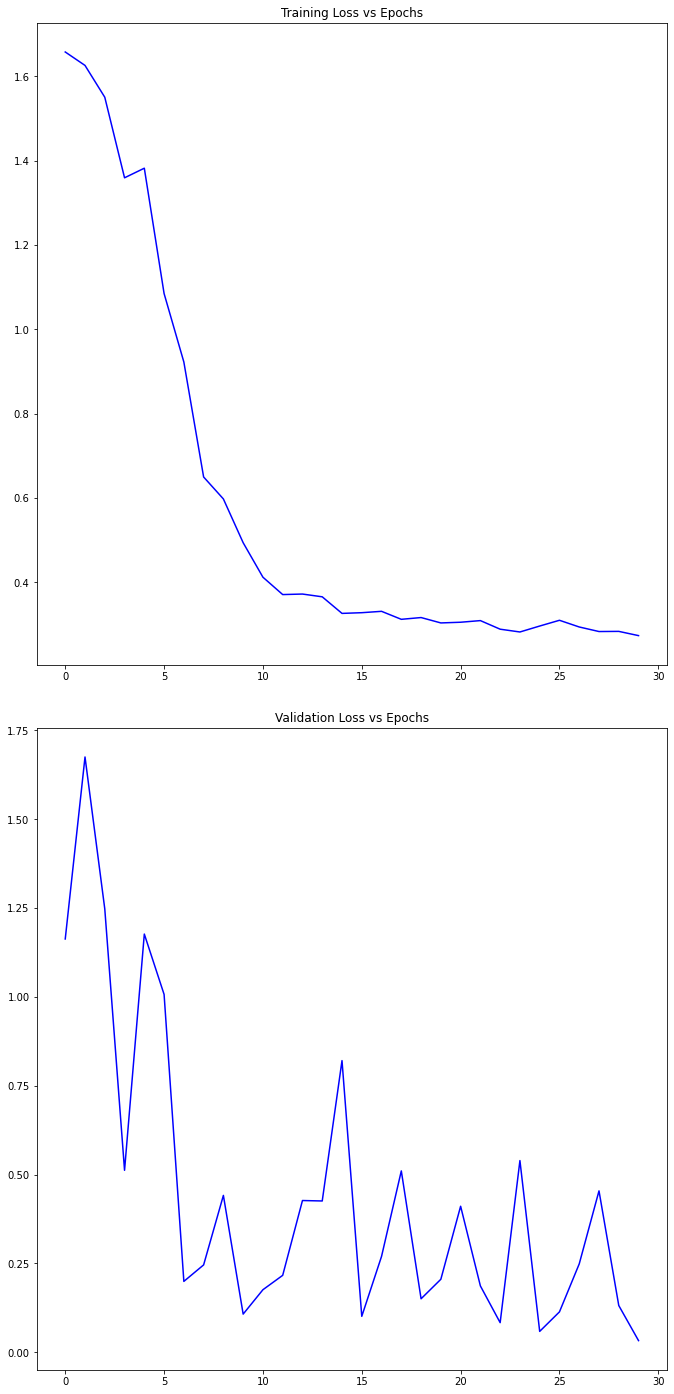

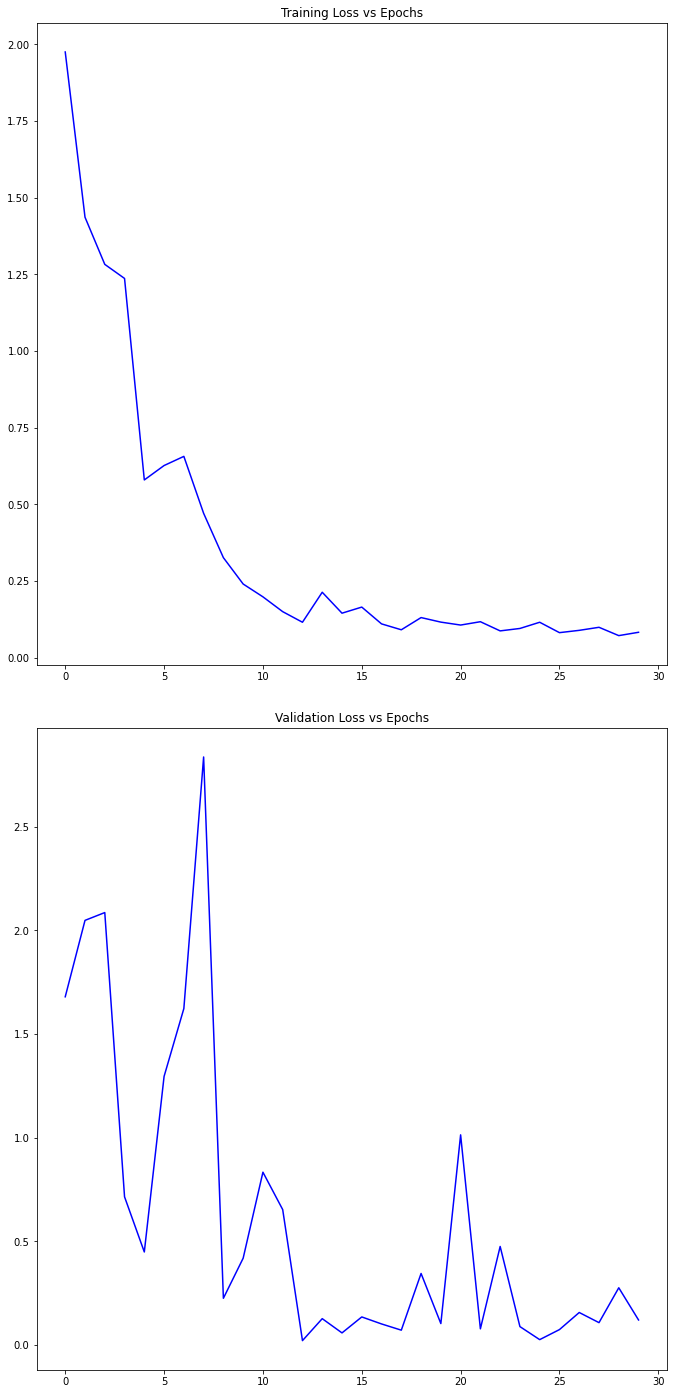

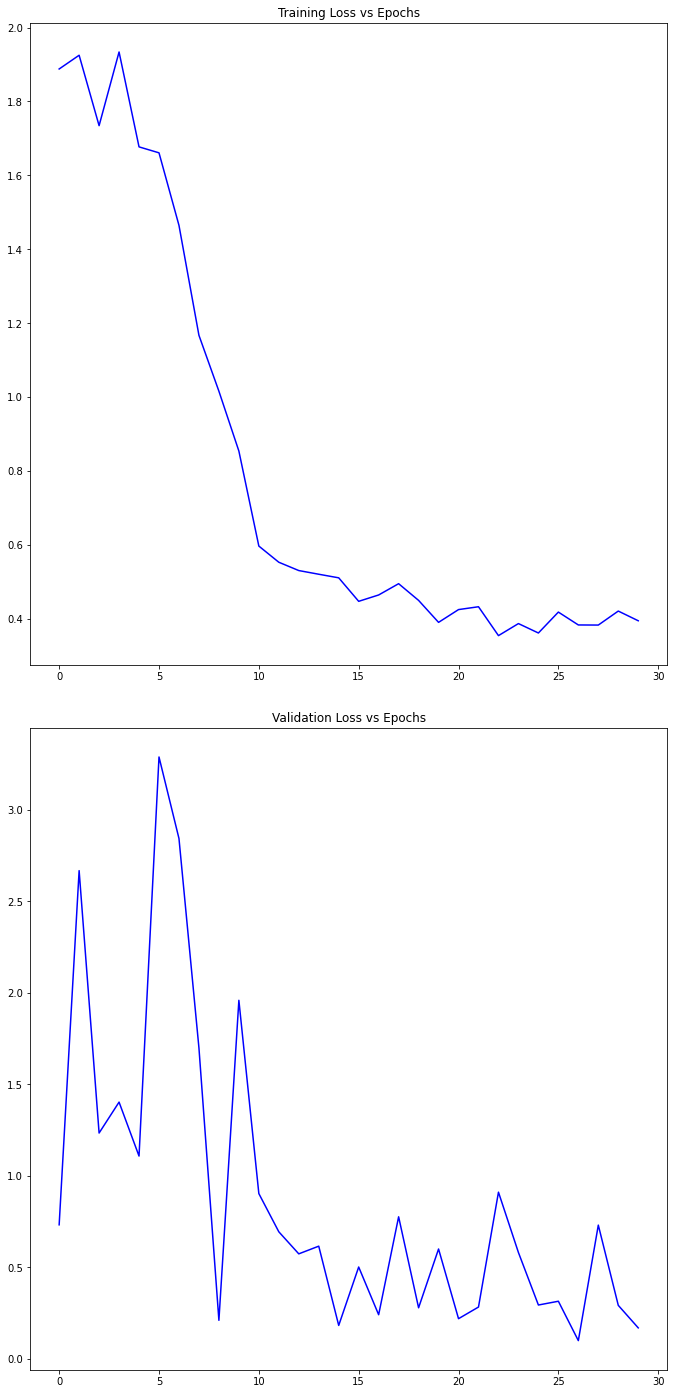

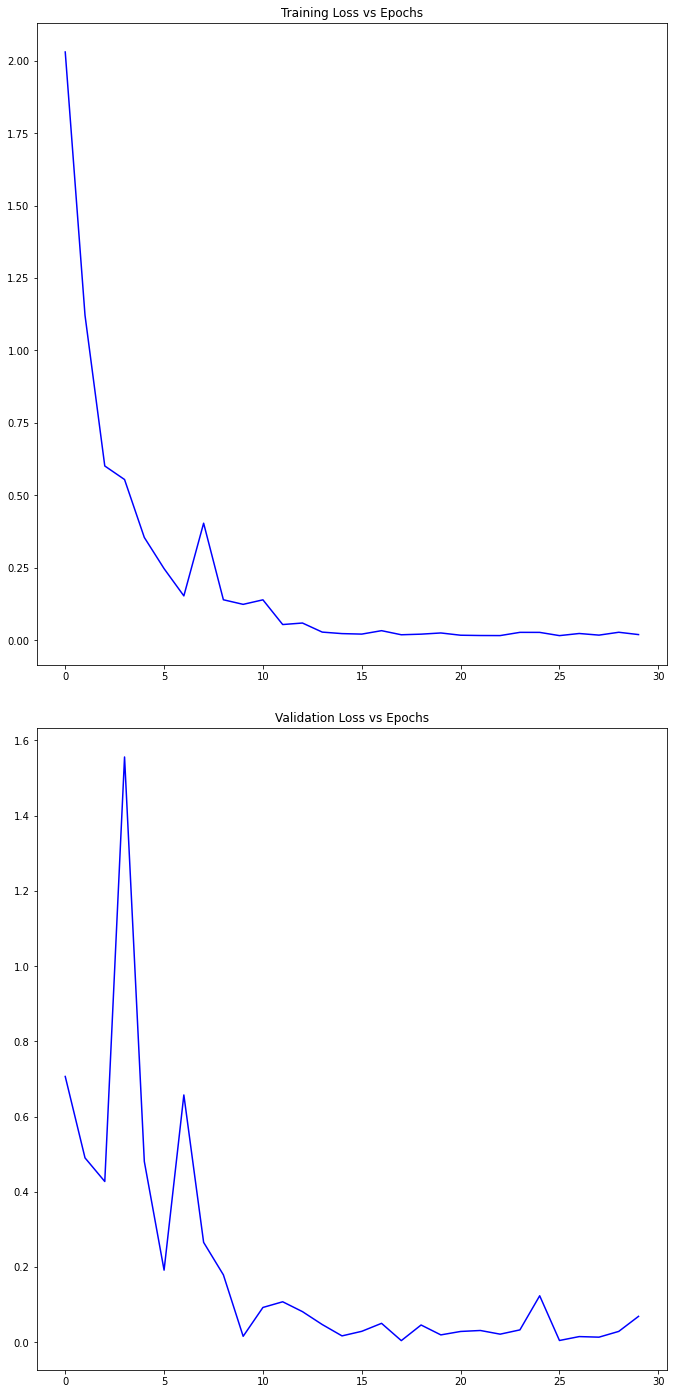

In [8]:
# use single iteration to compare against AuxLoss models
iterations = 1

# Augmented Anterior Models
A_best_f1_aug = 0
A_f1_aug = []
A_prec_aug = []
A_rec_aug = []
A_area_aug = []
A_confusion_aug = []

for i in range(iterations):
    HeMIS, f1_score, precision, recall, auc, confusion_matrix = create_train_test('../Master_Anterior_HDW_MultiView.csv', augs=True)
    A_f1_aug.append(f1_score)
    A_prec_aug.append(precision)
    A_rec_aug.append(recall)
    A_area_aug.append(auc)
    A_confusion_aug.append(confusion_matrix)
    if (f1_score > A_best_f1_aug):
            torch.save(HeMIS.state_dict(), './HeMISBestAnteriorAugWeight.pth')
            A_best_f1_aug = f1_score
            
print(A_f1_aug)
print(A_prec_aug)
print(A_rec_aug)
print(A_area_aug)
print(A_confusion_aug)
            
# Augmented Posterior Models
P_best_f1_aug = 0
P_f1_aug = []
P_prec_aug = []
P_rec_aug = []
P_area_aug = []
P_confusion_aug = []

for i in range(iterations):
    HeMIS, f1_score, precision, recall, auc, confusion_matrix = create_train_test('../Master_Posterior_HDW_MultiView.csv', augs=True)
    P_f1_aug.append(f1_score)
    P_prec_aug.append(precision)
    P_rec_aug.append(recall)
    P_area_aug.append(auc)
    P_confusion_aug.append(confusion_matrix)
    if (f1_score > P_best_f1_aug):
            torch.save(HeMIS.state_dict(), './HeMISBestPosteriorAugWeght.pth')
            P_best_f1_aug = f1_score

print(P_f1_aug)
print(P_prec_aug)
print(P_rec_aug)
print(P_area_aug)
print(P_confusion_aug)            

# Non-Augmented Anterior Models
A_best_f1_Naug = 0
A_f1_Naug = []
A_prec_Naug = []
A_rec_Naug = []
A_area_Naug = []
A_confusion_Naug = []

for i in range(iterations):
    HeMIS, f1_score, precision, recall, auc, confusion_matrix = create_train_test('../Master_Anterior_HDW_MultiView.csv', augs=False)
    A_f1_Naug.append(f1_score)
    A_prec_Naug.append(precision)
    A_rec_Naug.append(recall)
    A_area_Naug.append(auc)
    A_confusion_Naug.append(confusion_matrix)
    if (f1_score > A_best_f1_Naug):
            torch.save(HeMIS.state_dict(), './HeMISBestAnteriorNAugWeight.pth')
            A_best_f1_Naug = f1_score

print(A_f1_Naug)
print(A_prec_Naug)
print(A_rec_Naug)
print(A_area_Naug)
print(A_confusion_Naug)

# Non-Augmented Posterior Models
P_best_f1_Naug = 0
P_f1_Naug = []
P_prec_Naug = []
P_rec_Naug = []
P_area_Naug = []
P_confusion_Naug = []

for i in range(iterations):
    HeMIS, f1_score, precision, recall, auc, confusion_matrix = create_train_test('../Master_Posterior_HDW_MultiView.csv', augs=False)
    P_f1_Naug.append(f1_score)
    P_prec_Naug.append(precision)
    P_rec_Naug.append(recall)
    P_area_Naug.append(auc)
    P_confusion_Naug.append(confusion_matrix)
    if (f1_score > P_best_f1_Naug):
            torch.save(HeMIS.state_dict(), './HeMISBestPosteriorNAugWeight.pth')
            P_best_f1_Naug = f1_score

print(P_f1_Naug)
print(P_prec_Naug)
print(P_rec_Naug)
print(P_area_Naug)
print(P_confusion_Naug) 